In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import pandas as pd
#from chart_studio import plotly as py
#import plotly.figure_factory as ff
from scipy import stats

import gensim
import json


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import itertools

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')



Using TensorFlow backend.


In [5]:
#initializing the wordnet lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
# setting a window size of 10. There are 5 classes/levels of depression we wish to classify.
WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

In [7]:
# IMPORTANT - make plots more detailed

# plots training and validation accuracy v/s epochs
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# plots training and validation loss v/s epochs
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# compares the losses between the two models
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()

# compares the accuracies betweeen the two models
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

# can compare across multiple metrics given the appropriate parameters
def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

In [8]:
# converts all the transcripts files to a dataframe that consists of questions and answers of all person Ids
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            print(filename)
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all.csv', sep=',')
    print("File was created")
    return all_participants

In [11]:
# read the dataframe we had saved earlier, if we had done so
data_path = 'C:/DepData/transcripts/'
#transcripts_to_dataframe(data_path) 
all_participants = pd.read_csv(data_path + 'all.csv', sep=',')

In [15]:
all_participants.columns =  ['index','personId', 'question', 'answer']
all_participants = all_participants.astype({"index": int, "personId": float, "question": str, "answer": str })
all_participants.head()

,index,personId,question,answer
0,0,300.0,hi i'm ellie thanks for coming in today,nan
1,1,300.0,i was created to talk to people in a safe and ...,nan
2,2,300.0,think of me as a friend i don't judge i can't ...,nan
3,3,300.0,i'm here to learn about people and would love ...,nan
4,4,300.0,i'll ask a few questions to get us started and...,nan


In [13]:
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [14]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to C:\Users\K N
[nltk_data]     PRASAD\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to C:\Users\K N
[nltk_data]     PRASAD\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
# crate a copy of the original dataframe, that stores answers as a list, after preprocessing - removing stopwords
all_participants_mix = all_participants.copy()
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)
all_participants_mix.tail()

,index,personId,question,answer
14968,14968,492.0,mm,[]
14969,14969,492.0,what are you most proud of in your life,"[um, proud, fact, uh, give]"
14970,14970,492.0,okay i think i have asked everything i need to,[]
14971,14971,492.0,thanks for sharing your thoughts with me,[]
14972,14972,492.0,goodbye,"[bye, thank]"


In [17]:
# creates a copy of the original dataframe, with answers processed as a list of words - but removal of stopwords is not done
all_participants_mix_stopwords = all_participants.copy()
all_participants_mix_stopwords['answer'] = all_participants_mix_stopwords.apply(lambda row: text_to_wordlist(row.answer, remove_stopwords=False).split(), axis=1)
all_participants_mix_stopwords.tail()

,index,personId,question,answer
14968,14968,492.0,mm,[]
14969,14969,492.0,what are you most proud of in your life,"[um, i, am, very, proud, of, the, fact, that, ..."
14970,14970,492.0,okay i think i have asked everything i need to,[]
14971,14971,492.0,thanks for sharing your thoughts with me,[]
14972,14972,492.0,goodbye,"[bye, and, thank, you]"


In [18]:
# create a vocabulary of all words used in the answers - after removing stopwords
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words))
vocab_size = len(words)
print(vocab_size)

7373


In [19]:
# create a vocabulary of all words used in the answers - without removing stopwords
words_stop = [w for w in all_participants_mix_stopwords['answer'].tolist()]
words_stop = set(itertools.chain(*words_stop))
vocab_size_stop = len(words_stop)
print(vocab_size_stop)

7449


In [70]:
# associate each word with an index in the vocabulary
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer'])
tokenizer.fit_on_sequences(all_participants_mix['answer'])

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix.tail()

,index,personId,question,answer,t_answer
14968,14968,492.0,mm,[],[]
14969,14969,492.0,what are you most proud of in your life,"[um, proud, fact, uh, give]","[1, 147, 265, 2, 165]"
14970,14970,492.0,okay i think i have asked everything i need to,[],[]
14971,14971,492.0,thanks for sharing your thoughts with me,[],[]
14972,14972,492.0,goodbye,"[bye, thank]","[858, 173]"


In [21]:
# do the same for the answers with stopwords
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size_stop)
tokenizer.fit_on_texts(all_participants_mix_stopwords['answer'])
tokenizer.fit_on_sequences(all_participants_mix_stopwords['answer'])

all_participants_mix_stopwords['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix_stopwords['answer'])
all_participants_mix_stopwords.tail()

,index,personId,question,answer,t_answer
14968,14968,492.0,mm,[],[]
14969,14969,492.0,what are you most proud of in your life,"[um, i, am, very, proud, of, the, fact, that, ...","[5, 1, 18, 49, 224, 13, 7, 353, 8, 9, 1, 19, 1..."
14970,14970,492.0,okay i think i have asked everything i need to,[],[]
14971,14971,492.0,thanks for sharing your thoughts with me,[],[]
14972,14972,492.0,goodbye,"[bye, and, thank, you]","[949, 2, 254, 11]"


In [23]:
# testing the word index built so
word_index = tokenizer.word_index
word_size = len(word_index)
print("Word size: ", word_size)
print(word_index['laughter'])

Word size:  7449
28


In [39]:
# create another dataframe - phrases_lp_stop that consists of three columns Id, answer and tokenized answer
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp_stop = pd.DataFrame(columns=['personId','answer', 't_answer'])
# the list below consists of all answers (which include stopwords) of one person grouped together
answers = all_participants_mix_stopwords.groupby('personId').agg({'answer':['sum'], 't_answer':['sum']})
print(answers['answer'])

                                                        sum
personId                                                   
300.0     [good, atlanta, georgia, um, my, parent, are, ...
301.0     [thank, you, mmm, k, i, am, doing, good, thank...
302.0     [i, am, fine, how, about, yourself, i, am, fro...
303.0     [okay, how, bout, yourself, here, in, californ...
304.0     [i, am, doing, good, um, from, los, angeles, c...
...                                                     ...
488.0     [yes, fine, oh, san, fernando, valley, uh, wel...
489.0     [yes, i, am, doing, well, thank, you, san, lui...
490.0     [yeah, i, am, doing, already, how, are, you, d...
491.0     [yes, huh, overwhelmed, i, have, a, funeral, t...
492.0     [yes, doing, pretty, good, thank, you, marylan...

[186 rows x 1 columns]


In [45]:
# phrases_lp_stop is built - it holds a sliding window of 10 answers and tokens of those answers
cont = 0
for p in answers.iterrows():
    words = p[1]['answer']['sum']
    size = len(words)
    word_tokens = p[1]["t_answer"]['sum']
    print(cont)
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp_stop.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

0
366
1910
2537
4564
5586
9031
10645
13317
14253
14978
16167
16840
18094
18864
22270
23681
24333
25004
25734
26438
27229
28181
29783
31179
32089
33961
34490
35308
37387
38393
38893
40421
41348
42739
44279
45715
46737
51500
52373
53416
54025
55336
56086
58111
59615
61954
62412
63425
64967
66450
67651
69384
70677
71189
72243
73920
74343
75023
77376
78019
79352
80184
82410
86641
89041
91691
94841
98498
100818
104009
104853
107126
110843
113307
113865
115659
118143
119495
122094
126155
127879
129032
131212
132345
132527
134731
135297
135775
136363
137814
138437
139156
139911
141173
142312
144098
145299
146517
147752
148927
150409
151498
154051
155105
158365
159245
161725
163222
166294
167179
168929
170431
171685
173201
174465
176141
177836
178954
180049
182566
183609
186170
187978
189206
190309
191330
192564
194061
194949
196252
197200
199869
200911
202344
203590
206969
210093
211990
212964
214603
215140
218037
219080
220873
222305
224942
228109
230186
230789
232313
233009
234107
235798
23

In [46]:
phrases_lp_stop.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, my, parent, are, ...","[42, 1727, 2089, 5, 12, 205, 37, 69, 113, 5]"
1,300.0,"[atlanta, georgia, um, my, parent, are, from, ...","[1727, 2089, 5, 12, 205, 37, 69, 113, 5, 1]"
2,300.0,"[georgia, um, my, parent, are, from, here, um,...","[2089, 5, 12, 205, 37, 69, 113, 5, 1, 119]"
3,300.0,"[um, my, parent, are, from, here, um, i, love,...","[5, 12, 205, 37, 69, 113, 5, 1, 119, 6]"
4,300.0,"[my, parent, are, from, here, um, i, love, it, i]","[12, 205, 37, 69, 113, 5, 1, 119, 6, 1]"


In [48]:
# phrases_lp is similarly built for the answers without stopwords
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix.groupby('personId').agg({'answer':['sum'], 't_answer':['sum']})

for p in answers.iterrows():      
    words = p[1]["answer"]['sum']
    size = len(words)
    word_tokens = p[1]["t_answer"]['sum']
    print(cont)
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

0
216
948
1289
2306
2820
4467
5272
6634
7128
7522
8134
8492
9114
9541
11143
11859
12199
12612
12990
13364
13740
14193
15043
15774
16260
17226
17541
17988
18998
19510
19807
20537
21021
21756
22506
23241
23777
25875
26337
26890
27214
27861
28208
29187
30033
31162
31393
31906
32726
33442
34097
34961
35630
35916
36462
37272
37520
37921
39117
39453
40176
40612
41633
43633
44724
46096
47446
49283
50470
52061
52512
53621
55410
56647
56942
57855
59048
59743
61122
63171
63974
64588
65735
66337
66430
67611
67925
68167
68473
69276
69612
69995
70382
71056
71623
72482
73094
73766
74375
74966
75725
76316
77554
78141
79799
80270
81574
82292
83751
84254
85067
85771
86414
87162
87834
88666
89515
90086
90618
91842
92382
93546
94464
95095
95675
96222
96897
97670
98152
98855
99358
100583
101171
101863
102549
104204
105711
106599
107096
107951
108286
109691
110175
111096
111794
113099
114452
115480
115793
116535
116938
117489
118336
119083
119717
120237
121265
121723
122828
124247
125620
126288
127310
1282

In [49]:
phrases_lp.to_csv(data_path + 'phrases_lp.csv', sep='\t')
print("File was created")

File was created


In [50]:
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, parent, um, love,...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,300.0,"[atlanta, georgia, um, parent, um, love, like,...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,300.0,"[georgia, um, parent, um, love, like, weather,...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,300.0,"[um, parent, um, love, like, weather, like, op...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,300.0,"[parent, um, love, like, weather, like, opport...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [60]:
# for entries having a lower window size, 0's are padded
phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
phrases_lp.tail()

,Unnamed: 0,personId,answer,t_answer
142807,142807,492.0,"['fact', 'uh', 'give', 'bye', 'thank']","[2, 165, 858, 173, 0, 0, 0, 0, 0, 0]"
142808,142808,492.0,"['uh', 'give', 'bye', 'thank']","[165, 858, 173, 0, 0, 0, 0, 0, 0, 0]"
142809,142809,492.0,"['give', 'bye', 'thank']","[858, 173, 0, 0, 0, 0, 0, 0, 0, 0]"
142810,142810,492.0,"['bye', 'thank']","[173, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
142811,142811,492.0,['thank'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [52]:
phrases_lp_stop.to_csv(data_path + 'phrases_lp_stop.csv', sep='\t')
print("File was created")

File was created


In [53]:
phrases_lp = pd.read_csv(data_path + 'phrases_lp.csv', sep='\t', converters={"t_answer": literal_eval}) 
phrases_lp.head()

,Unnamed: 0,personId,answer,t_answer
0,0,300.0,"['good', 'atlanta', 'georgia', 'um', 'parent',...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,1,300.0,"['atlanta', 'georgia', 'um', 'parent', 'um', '...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,2,300.0,"['georgia', 'um', 'parent', 'um', 'love', 'lik...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,3,300.0,"['um', 'parent', 'um', 'love', 'like', 'weathe...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,4,300.0,"['parent', 'um', 'love', 'like', 'weather', 'l...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [56]:
# this function loads the necessary train, dev and test files that contain the levels of depression for each participant
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [57]:
# loading all three into respective dataframes
train = load_avec_dataset_file(data_path + 'train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file(data_path + 'dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file(data_path + 'full_test_split.csv', 'PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


In [58]:
# the dataframe ds_total holds all data from train, dev and test
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [59]:
ds_total.to_csv(data_path + 'ds_total.csv', sep = '\t')
print('done')

done


In [61]:
# this function takes the dataframe as input and splits it into 5 different dataframes, each for a different depression level
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [62]:
# The five level based dataframes are obtained
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


In [63]:
# to ensure we have equally distributed data, we sample the above five dataframes at 26, and recombine them all to get
# ds_total_b

b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(b_none_ds), len(b_mild_ds), len(b_moderate_ds), len(b_moderate_severe_ds), len(b_severe_ds)))

Quantity per none_ds: 26, mild_ds: 26, moderate_ds 26, moderate_severe_ds: 24, severe_ds 22


In [64]:
# we combine the transcripts data (the one without stopwords) and the depression level data obtained above
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')

In [65]:
# this function splits a given dataframe uniformly into the three classes - train, dev and test
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

In [66]:
# we obtain the train, dev and test dataframes using the function defined above
# we must remember, that the dataframes underscored by "b" were ones where we sampled individual level dataframes by 26.
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

In [67]:
train_lp.tail()

,Participant_ID,level,cat_level,PHQ8_Score,Unnamed: 0,personId,answer,t_answer
82378,367.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",19,46370,367.0,"['started', 'write', 'short', 'story', 'longer...","[223, 502, 510, 683, 709, 400, 488, 3, 13, 1562]"
96660,440.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",19,106034,440.0,"['know', 'point', 'gonna', 'come', 'um', 'yeah...","[4, 221, 103, 113, 1, 11, 20, 2, 29, 53]"
17977,348.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",20,31450,348.0,"['i', 'am', 'pretty', 'outgoing', 'talk', 'peo...","[3, 6, 23, 155, 119, 14, 211, 194, 14, 119]"
134734,453.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",17,116182,453.0,"['sleep', 'laughter', 'try', 'laughter', 'um',...","[77, 8, 62, 8, 1, 25, 1, 22, 1259, 2]"
68403,459.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",16,119298,459.0,"['i', 'am', 'going', 'work', 'week', 'make', '...","[3, 6, 40, 53, 148, 45, 30, 82, 135, 387]"


In [68]:
# this function builds a confusion matrix, given our model, the inputs and the corresponding outputs
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [69]:
# we load GloVe embeddings, that give us a vector for every word
# the embeddings we use are characterized by 6 billion tokens (6B), 100 dimensional vectors (100d) with a vocab of 400k words.
# we form a dictionary - for every word and it's respective coefficients into "embeddings_index"
embeddings_index = dict()
f = open(data_path + 'glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [71]:
# for our dataset, we had used the tokenizer earlier on answers not having stopwords, to convert them into tokens
# now, we form an embeddings matrix specifically for each word in our vocabulary
# every row contains one vector corresponding to every row in the tokenizer, i.e. for each word.
def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index)
    embedding_matrix = np.zeros((vocab_size+1, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [72]:
# we obtain the embeddings matrix from the above function
embedding_matrix_lp = fill_embedding_matrix(tokenizer)

In [73]:
train_lp.tail()

,Participant_ID,level,cat_level,PHQ8_Score,Unnamed: 0,personId,answer,t_answer
82378,367.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",19,46370,367.0,"['started', 'write', 'short', 'story', 'longer...","[223, 502, 510, 683, 709, 400, 488, 3, 13, 1562]"
96660,440.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",19,106034,440.0,"['know', 'point', 'gonna', 'come', 'um', 'yeah...","[4, 221, 103, 113, 1, 11, 20, 2, 29, 53]"
17977,348.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",20,31450,348.0,"['i', 'am', 'pretty', 'outgoing', 'talk', 'peo...","[3, 6, 23, 155, 119, 14, 211, 194, 14, 119]"
134734,453.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",17,116182,453.0,"['sleep', 'laughter', 'try', 'laughter', 'um',...","[77, 8, 62, 8, 1, 25, 1, 22, 1259, 2]"
68403,459.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",16,119298,459.0,"['i', 'am', 'going', 'work', 'week', 'make', '...","[3, 6, 40, 53, 148, 45, 30, 82, 135, 387]"


In [83]:
# train_lp_copy = train_lp
# print(len(train_lp_copy))
# for index,row in train_lp_copy.iterrows():
#     if len(row['t_answer'])<10:
#         train_lp_copy.drop(index,inplace=True)
# print(len(train_lp_copy))        
# train_lp = train_lp_copy

99969
99969


In [76]:
# dev_lp_copy = dev_lp
# print(len(dev_lp_copy))
# for index,row in dev_lp_copy.iterrows():
#     if len(row['t_answer'])<10:
#         dev_lp_copy.drop(index,inplace=True)
# print(len(dev_lp_copy))  
# dev_lp = dev_lp_copy

19993
19993


In [77]:
# test_lp_copy = test_lp
# print(len(test_lp_copy))
# for index,row in test_lp_copy.iterrows():
#     if len(row['t_answer'])<10:
#         test_lp_copy.drop(index,inplace=True)
# print(len(test_lp_copy))  
# test_lp = test_lp_copy

22849
22849


In [79]:
# here, we stack up all the answer tokens (input to our model), 
# and all the depression levels which are one-hot encoded (target outputs of our model)
train_a = np.stack(train_lp['t_answer'], axis=0)
dev_a = np.stack(dev_lp['t_answer'], axis=0)
train_y = np.stack(train_lp['cat_level'], axis=0)
dev_y = np.stack(dev_lp['cat_level'], axis=0)

In [80]:
# train_lp_b_copy = train_lp_b
# print(len(train_lp_b_copy))
# for index,row in train_lp_b_copy.iterrows():
#     if len(row['t_answer'])<10:
#         train_lp_b_copy.drop(index,inplace=True)
# print(len(train_lp_b_copy))  
# train_lp_b = train_lp_b_copy

68842
68842


In [81]:
# dev_lp_b_copy = dev_lp_b
# print(len(dev_lp_b_copy))
# for index,row in dev_lp_b_copy.iterrows():
#     if len(row['t_answer'])<10:
#         dev_lp_b_copy.drop(index,inplace=True)
# print(len(dev_lp_b_copy))  
# dev_lp_b = dev_lp_b_copy

13768
13768


In [82]:
# test_lp_b_copy = test_lp_b
# print(len(test_lp_b_copy))
# for index,row in test_lp_b_copy.iterrows():
#     if len(row['t_answer'])<10:
#         test_lp_b_copy.drop(index,inplace=True)
# print(len(test_lp_b_copy))  
# test_lp_b = test_lp_b_copy

15734
15734


In [84]:
# similarly, we do the similar stacking for the dataframes without class imbalance, but lesser data
train_a_b = np.stack(train_lp_b['t_answer'], axis=0)
dev_a_b = np.stack(dev_lp_b['t_answer'], axis=0)
train_y_b = np.stack(train_lp_b['cat_level'], axis=0)
dev_y_b = np.stack(dev_lp_b['cat_level'], axis=0)

In [85]:
# we set up an early stopping criterion, for validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [86]:
# ----- MODEL DEFINITION ---------

# define an input layer with windows_size number of nodes
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
# add an embedding layer with weights obtained from matrix, and we're not going to train it because it's already trained
answer_emb1 = Embedding(vocab_size+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

# accelerate training using Batch Normalization
bt = BatchNormalization()(answer_emb1)

# an LSTM layer with 20% dropout
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

# two dense layers with ReLU activation 
dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

# a flatten layer - converts output into a 1 D format
flatten = Flatten()(dense2)

# final dense layer with softmax activation, for 5 units
out = Dense(5,  activation='softmax')(flatten)

# construct the model with the answer_inp and out layers
model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           737400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           25856     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 256)           65792     
____________________________________________

In [87]:
# train the model, with input dataframes having imbalanced classes
model_glove_lstm_hist = model.fit(train_a, train_y, validation_data=(dev_a, dev_y), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])


Train on 99969 samples, validate on 19993 samples
Epoch 1/30
99969/99969 [==============================] - 50s 499us/step - loss: 1.4467 - accuracy: 0.3783 - val_loss: 1.3333 - val_accuracy: 0.4415
Epoch 2/30
99969/99969 [==============================] - 48s 482us/step - loss: 1.2767 - accuracy: 0.4681 - val_loss: 1.0907 - val_accuracy: 0.5589
Epoch 3/30
99969/99969 [==============================] - 49s 488us/step - loss: 1.1106 - accuracy: 0.5488 - val_loss: 0.9291 - val_accuracy: 0.6429
Epoch 4/30
99969/99969 [==============================] - 49s 488us/step - loss: 1.0000 - accuracy: 0.6011 - val_loss: 0.7970 - val_accuracy: 0.7021
Epoch 5/30
99969/99969 [==============================] - 48s 479us/step - loss: 0.9180 - accuracy: 0.6389 - val_loss: 0.7182 - val_accuracy: 0.7351
Epoch 6/30
99969/99969 [==============================] - 49s 486us/step - loss: 0.8622 - accuracy: 0.6621 - val_loss: 0.6501 - val_accuracy: 0.7577
Epoch 7/30
99969/99969 [==============================]

In [91]:
# train the model, but this time use balanced classes (sampled by 26!)
model_glove_lstm_hist_b = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 68842 samples, validate on 13768 samples
Epoch 1/30
68842/68842 [==============================] - 34s 492us/step - loss: 0.1697 - accuracy: 0.9407 - val_loss: 0.0349 - val_accuracy: 0.9885
Epoch 2/30
68842/68842 [==============================] - 32s 470us/step - loss: 0.1699 - accuracy: 0.9403 - val_loss: 0.0338 - val_accuracy: 0.9895
Epoch 3/30
68842/68842 [==============================] - 33s 474us/step - loss: 0.1638 - accuracy: 0.9416 - val_loss: 0.0308 - val_accuracy: 0.9906
Epoch 4/30
68842/68842 [==============================] - 33s 475us/step - loss: 0.1633 - accuracy: 0.9417 - val_loss: 0.0333 - val_accuracy: 0.9890
Epoch 5/30
68842/68842 [==============================] - 33s 485us/step - loss: 0.1651 - accuracy: 0.9422 - val_loss: 0.0346 - val_accuracy: 0.9886
Epoch 6/30
68842/68842 [==============================] - 33s 486us/step - loss: 0.1608 - accuracy: 0.9430 - val_loss: 0.0335 - val_accuracy: 0.9885


In [92]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a_b, test_y_b)

In [93]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3560,14,5,11,3
mild,25,3443,11,17,13
moderate,14,11,3320,11,12
moderately severe,8,2,4,2821,8
severe,14,3,6,5,2393


In [94]:
score = model.evaluate(test_a_b, test_y_b, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15734/15734 [==============================] - 4s 255us/step
Test loss: 0.03813559517118281
Test accuracy: 0.9874793291091919


In [95]:
model.save(data_path + 'model_glove_lstm_b.h5')
json_dict = model_glove_lstm_hist.history
with open(data_path + 'model_glove_lstm_b_hist.json', 'w') as f:
    f.write(str(json_dict))
print('File got created')    

File got created


In [96]:
from keras.models import load_model
model = load_model(data_path + 'model_glove_lstm_b.h5')

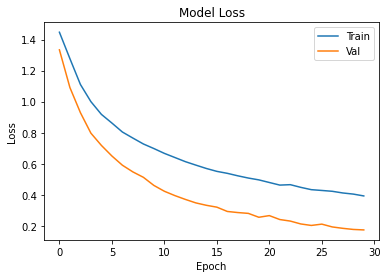

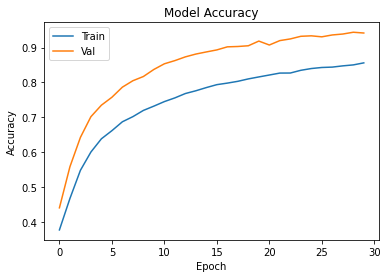

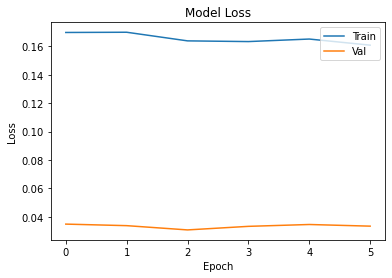

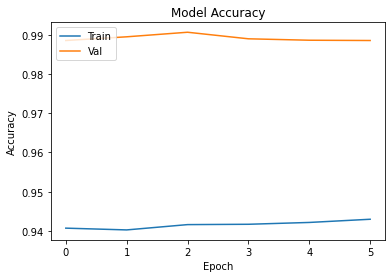

In [97]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)
plot_loss(model_glove_lstm_hist_b)
plot_acc(model_glove_lstm_hist_b)

In [100]:
def test_model(text, model):
    print(text)
    word_list = text_to_wordlist(text)
    sequences = tokenizer.texts_to_sequences([word_list])
    sequences_input = list(itertools.chain(*sequences))
    sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
    #print(sequences_input)
    input_a = np.asarray(sequences_input)
    pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
    predicted_class = np.argmax(pred)
    print(labels[predicted_class])

In [101]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model)
sen = "I am a graduate student"
test_model(sen, model)
sen = "I am getting married"
test_model(sen, model)
sen = "This party is great, I know lots of people"
test_model(sen, model)
sen = "I miss my parents, brothers and sisters"
test_model(sen, model)
sen = "I detest my horrible job"
test_model(sen, model)
sen = "suicide"
test_model(sen, model)

All is going right with the party, I'm happy to know new people
mild
I want an ice cream and have some fries for lunch
moderately severe
I'm afraid of losing my work, I don't have any money
severe
I'm worried about my future, I'm afraid of it
severe
I am a graduate student
none
I am getting married
none
This party is great, I know lots of people
none
I miss my parents, brothers and sisters
mild
I detest my horrible job
severe
suicide
severe


In [103]:
# define a second model, similar to the first one, with an additional LSTM layer
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

lstm1 = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(answer_emb1)
lstm2 = LSTM(embedding_size_glove, dropout=0.2, recurrent_dropout=0.2)(lstm1)

X = Dropout(0.2)(lstm2)
bt = BatchNormalization()(X)
dense1 = Dense(units=256, activation="relu")(bt)

out = Dense(5,  activation='softmax')(dense1)

model_2lstm = Model(inputs=[answer_inp], outputs=[out])
model_2lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_2lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 100)           737400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2585

In [104]:
model_glove_2lstm_b_hist = model_2lstm.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 68842 samples, validate on 13768 samples
Epoch 1/30
68842/68842 [==============================] - 27s 392us/step - loss: 1.6044 - accuracy: 0.2583 - val_loss: 1.5905 - val_accuracy: 0.2961
Epoch 2/30
68842/68842 [==============================] - 32s 461us/step - loss: 1.5520 - accuracy: 0.3004 - val_loss: 1.5089 - val_accuracy: 0.3367
Epoch 3/30
68842/68842 [==============================] - 32s 470us/step - loss: 1.5085 - accuracy: 0.3334 - val_loss: 1.4598 - val_accuracy: 0.3759
Epoch 4/30
68842/68842 [==============================] - 33s 485us/step - loss: 1.4488 - accuracy: 0.3737 - val_loss: 1.3910 - val_accuracy: 0.4223
Epoch 5/30
68842/68842 [==============================] - 30s 432us/step - loss: 1.3806 - accuracy: 0.4146 - val_loss: 1.2891 - val_accuracy: 0.4746
Epoch 6/30
68842/68842 [==============================] - 29s 415us/step - loss: 1.3173 - accuracy: 0.4485 - val_loss: 1.2154 - val_accuracy: 0.5099
Epoch 7/30
68842/68842 [==============================] 

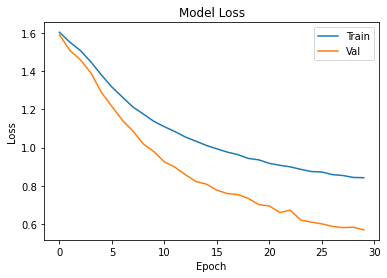

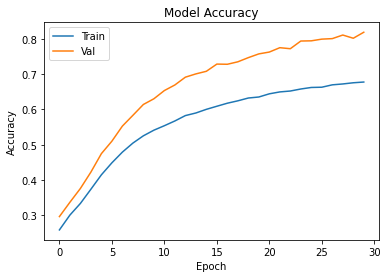

In [105]:
plot_loss(model_glove_2lstm_b_hist)
plot_acc(model_glove_2lstm_b_hist)

In [106]:
score = model_2lstm.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5711201358071819
Test accuracy: 0.8194991946220398


In [107]:
df_confusion = confusion_matrix(model_2lstm, test_a_b, test_y_b)

In [108]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3035,126,159,195,78
mild,261,2735,216,205,92
moderate,165,132,2820,177,74
moderately severe,137,104,118,2425,59
severe,123,132,116,171,1879


In [112]:
model_2lstm.save(data_path+'model_glove_2lstm_b.h5')
json_dict = model_glove_2lstm_b_hist.history
with open(data_path+'model_glove_2lstm_b_hist.json', 'w') as f:
    f.write(str(json_dict))
print('File got created')  

File got created


In [113]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_2lstm)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_2lstm)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model_2lstm)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model_2lstm)
sen = "My father loves me"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
none
I want an ice cream and have some fries for lunch
moderate
I'm afraid of losing my work, I don't have any money
mild
I'm worried about my future, I'm afraid of it
severe
My father loves me
moderate
